In [10]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from ast import literal_eval
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as sch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap.umap_ as umap
from matplotlib.colors import LinearSegmentedColormap
import ast

In [3]:
df = pd.read_csv('../data/wps_speeches_embeddings.csv')

In [4]:
df.head()

,filename,year,session number,text,speaker,country/organization,language,gender,only text,embeddings
0,UNSC_2000_SPV.4208_spch002.txt,2000,4208,The Secretary-General: Let me thank and congra...,The Secretary-General,NaN,English,u,Let me thank and congratulate the presidency ...,"[-0.00022651627659797668, -0.1448606550693512,..."
1,UNSC_2000_SPV.4208_spch004.txt,2000,4208,"Ms. King: I am particularly honoured today, as...",Ms. King,NaN,English,m,"I am particularly honoured today, as Special ...","[0.28913256525993347, -0.508164644241333, -0.8..."
2,UNSC_2000_SPV.4208_spch006.txt,2000,4208,Ms. Heyzer (United Nations Development Fund fo...,Ms. Heyzer,United Nations Development Fund for Women,English,f,I am honoured to participate in the Council's...,"[0.1997998207807541, -0.4322884678840637, -0.4..."
3,UNSC_2000_SPV.4208_spch008.txt,2000,4208,Miss Durrant (Jamaica): It is a pleasure to se...,Miss Durrant,Jamaica,English,f,"It is a pleasure to see you, the Foreign Mini...","[0.15298490226268768, -0.23061802983283997, -0..."
4,UNSC_2000_SPV.4208_spch010.txt,2000,4208,Ms. Soderberg (United States): The United Stat...,Ms. Soderberg,United States of America,English,f,The United States warmly welcomes this open d...,"[0.5181863307952881, -0.6662665009498596, -0.5..."


In [15]:
df['embeddings'] = df['embeddings'].apply(
    lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else np.array(x)
)
matrix = np.vstack(df.embeddings.values)
matrix.shape # number of speeches x number of embedding dimensions

(2566, 1024)

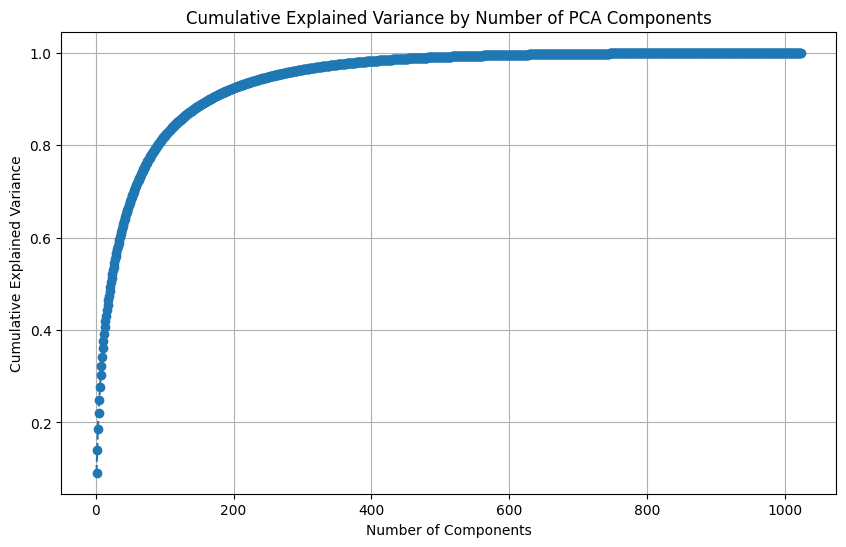

Number of components to retain 90.0% variance: 167
Original matrix shape: (2566, 1024)
PCA matrix shape: (2566, 167)


In [16]:
# first, we use PCA to reduce the dimensionality of the embeddings, so that we can later visualize them in 2D
pca = PCA().fit(matrix)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Number of PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

desired_variance = 0.9
num_components = np.argmax(cumulative_variance >= desired_variance) + 1

print(f"Number of components to retain {desired_variance*100}% variance: {num_components}")

pca = PCA(n_components=num_components)
pca_matrix = pca.fit_transform(matrix)

print(f"Original matrix shape: {matrix.shape}")
print(f"PCA matrix shape: {pca_matrix.shape}")

In [17]:
# next, we use t-SNE to further reduce the dimensionality of the embeddings to 2D
tsne = TSNE(n_components=2, perplexity=68, random_state=21, init='random', learning_rate=200) # setting perplexity to sqrt(4668) as per Oskolkov (2022)
vis_dims = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims]
y = [y for x, y in vis_dims]

df['x_tsne'] = x # dimension 1 as obtained from t-SNE
df['y_tsne'] = y # dimension 2 as obtained from t-SNE

In [18]:
tsne_pca = TSNE(n_components=2, perplexity=68, random_state=21, init='random', learning_rate=200) # setting perplexity to sqrt(4668) as per Oskolkov (2022)
vis_dims_pca = tsne_pca.fit_transform(pca_matrix)

x = [x for x, y in vis_dims_pca]
y = [y for x, y in vis_dims_pca]

df['x_pca_tsne'] = x # dimension 1 as obtained from t-SNE
df['y_pca_tsne'] = y # dimension 2 as obtained from t-SNE

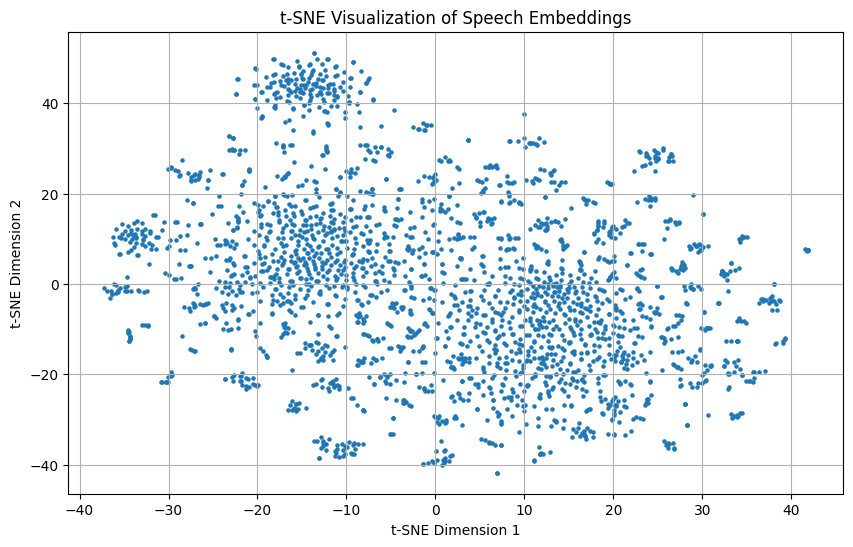

In [19]:
# plot a figure of the tsne results
plt.figure(figsize=(10, 6))
plt.scatter(df['x_tsne'], df['y_tsne'], s=5)
plt.title('t-SNE Visualization of Speech Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()

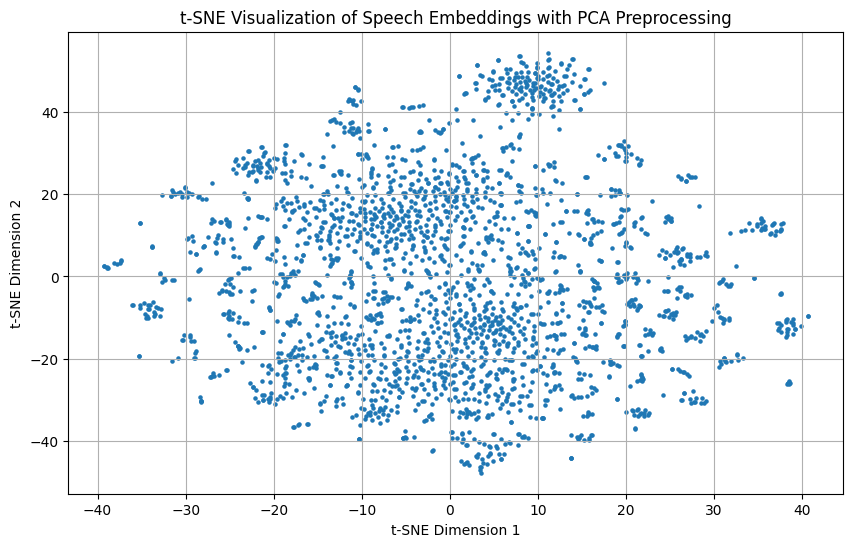

In [20]:
# plot a figure of the tsne results with pca preprocessing
plt.figure(figsize=(10, 6))
plt.scatter(df['x_pca_tsne'], df['y_pca_tsne'], s=5)
plt.title('t-SNE Visualization of Speech Embeddings with PCA Preprocessing')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


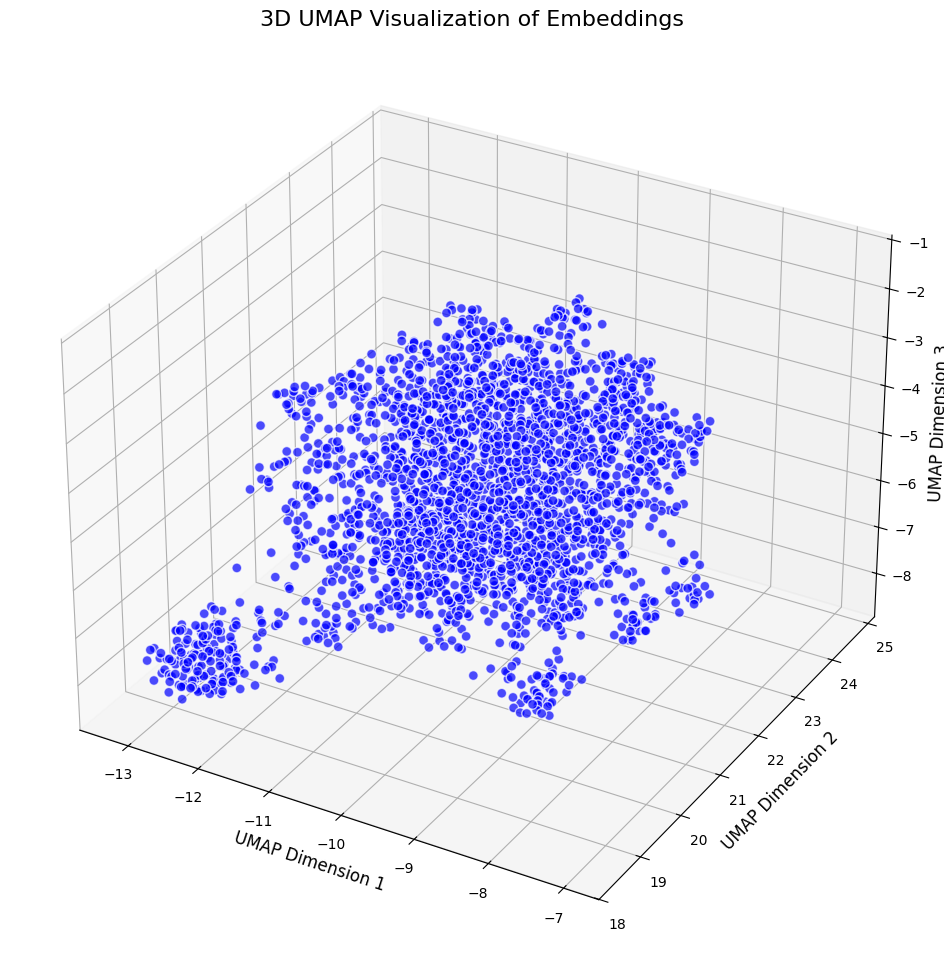

In [21]:
umap_model = umap.UMAP(n_components=3, n_neighbors=68, min_dist=0.5,init='random', random_state=88, n_jobs=1) 
# hyperparameters: 
# n_neighbors set to sqrt(144) (square root of the number of datapoints) as per Oskolkov (2022)
# n_components set to 5 as per Reades and Williams (2023) in order to capture more variance
vis_dims3 = umap_model.fit_transform(matrix)

df['x_umap'], df['y_umap'], df['z_umap'] = vis_dims3[:, 0], vis_dims3[:, 1], vis_dims3[:, 2]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    df['x_umap'], 
    df['y_umap'], 
    df['z_umap'], 
    c='blue',         
    marker='o',        
    edgecolors='w',   
    s=50,           
    alpha=0.7         
)

ax.set_xlabel('UMAP Dimension 1', fontsize=12)
ax.set_ylabel('UMAP Dimension 2', fontsize=12)
ax.set_zlabel('UMAP Dimension 3', fontsize=12)
ax.set_title('3D UMAP Visualization of Embeddings', fontsize=16)

plt.show()

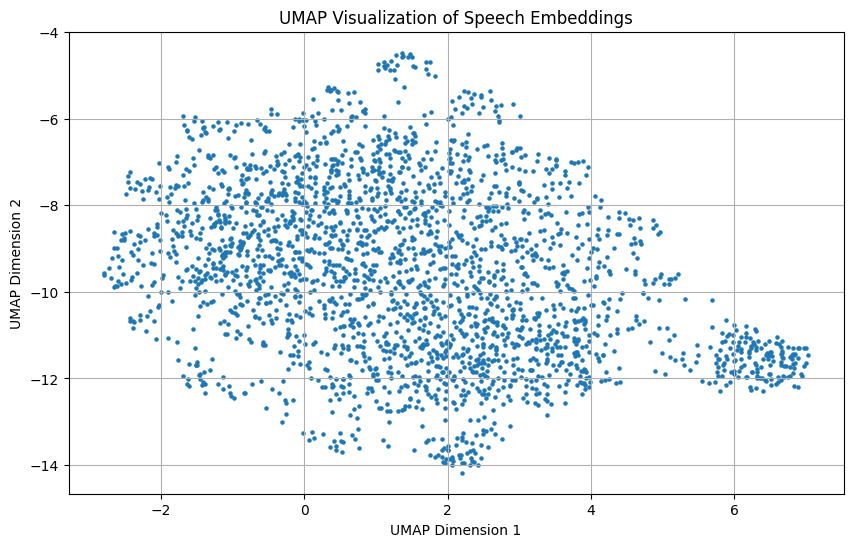

In [22]:
# UMAP with only two dimensions
umap_model = umap.UMAP(n_components=2, n_neighbors=68, min_dist=0.5,init='random', random_state=9, n_jobs=1)
vis_dims2 = umap_model.fit_transform(matrix)

df['x_umap2'], df['y_umap2'] = vis_dims2[:, 0], vis_dims2[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(df['x_umap2'], df['y_umap2'], s=5)
plt.title('UMAP Visualization of Speech Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True)
plt.show()

In [23]:
unique_years = sorted(df['year'].unique())
gradient_colors = LinearSegmentedColormap.from_list(
    "year_gradient", ['#5F0087', "#FFC0CB"], N=len(unique_years))

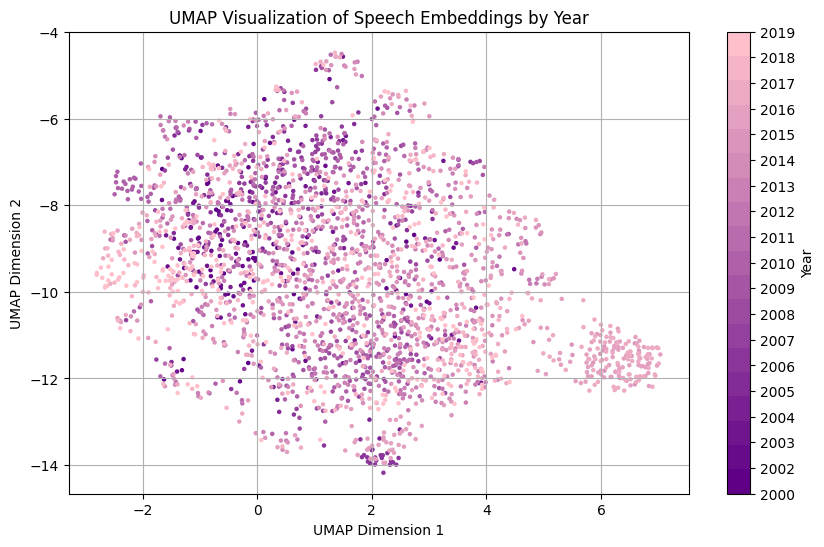

In [24]:
# umap visualization with color gradient by year
year_to_color = {y: i for i, y in enumerate(unique_years)}

plt.figure(figsize=(10, 6))
plt.scatter(
    df['x_umap2'], 
    df['y_umap2'], 
    c=df['year'].map(year_to_color),  
    cmap=gradient_colors,           
    s=5
)
plt.title('UMAP Visualization of Speech Embeddings by Year')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(
    ticks=range(len(unique_years)),
    label='Year',
    format=lambda i, _: unique_years[i]
)
plt.grid(True)
plt.show()


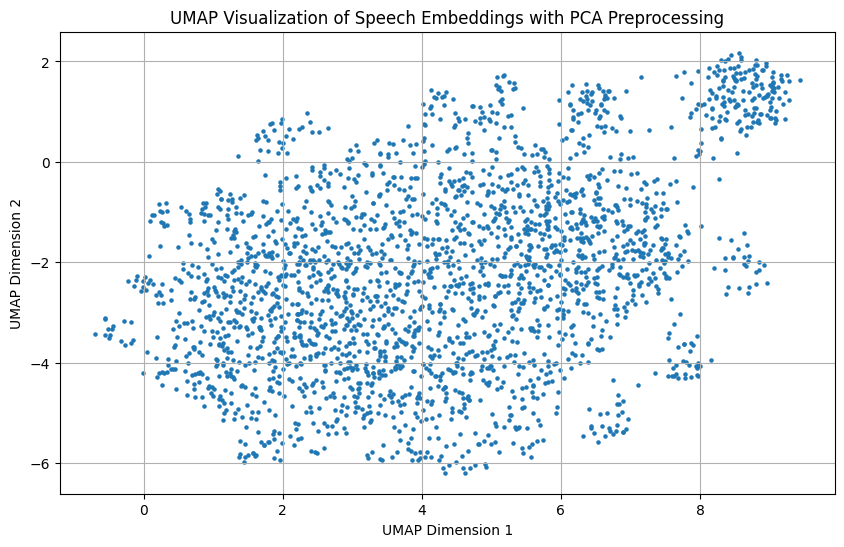

In [25]:
# umap visualization with 2 dimensions and pca preprocessing
umap_model = umap.UMAP(n_components=2, n_neighbors=68, min_dist=0.5,init='random', random_state=9, n_jobs=1)
vis_dims2_pca = umap_model.fit_transform(pca_matrix)

df['x_umap2_pca'], df['y_umap2_pca'] = vis_dims2_pca[:, 0], vis_dims2_pca[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(df['x_umap2_pca'], df['y_umap2_pca'], s=5)
plt.title('UMAP Visualization of Speech Embeddings with PCA Preprocessing')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True)
plt.show()

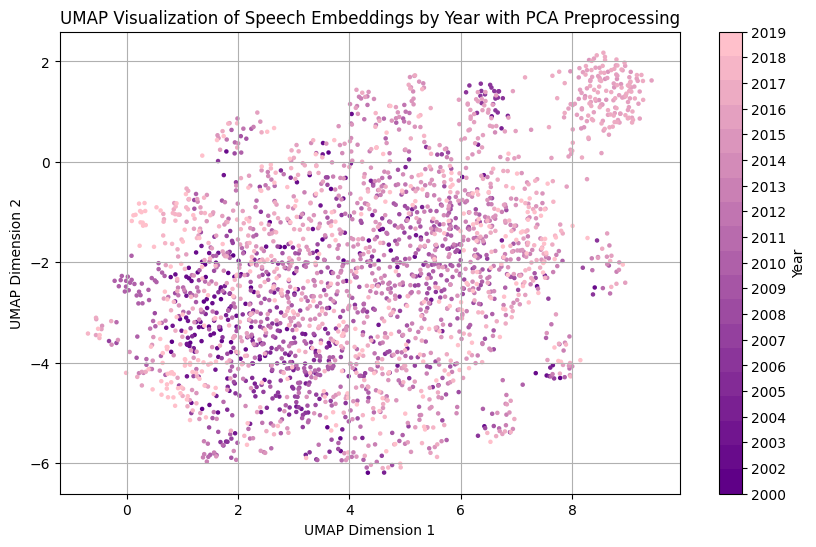

In [26]:
# add color marking by years to the UMAP plot with 2 dimensions
plt.figure(figsize=(10, 6))
plt.scatter(
    df['x_umap2_pca'], 
    df['y_umap2_pca'], 
    c=df['year'].map(year_to_color), 
    cmap=gradient_colors, 
    s=5
)
plt.title('UMAP Visualization of Speech Embeddings by Year with PCA Preprocessing')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(
    ticks=range(len(unique_years)),
    label='Year',
    format=lambda i, _: unique_years[i]
)
plt.grid(True)
plt.show()

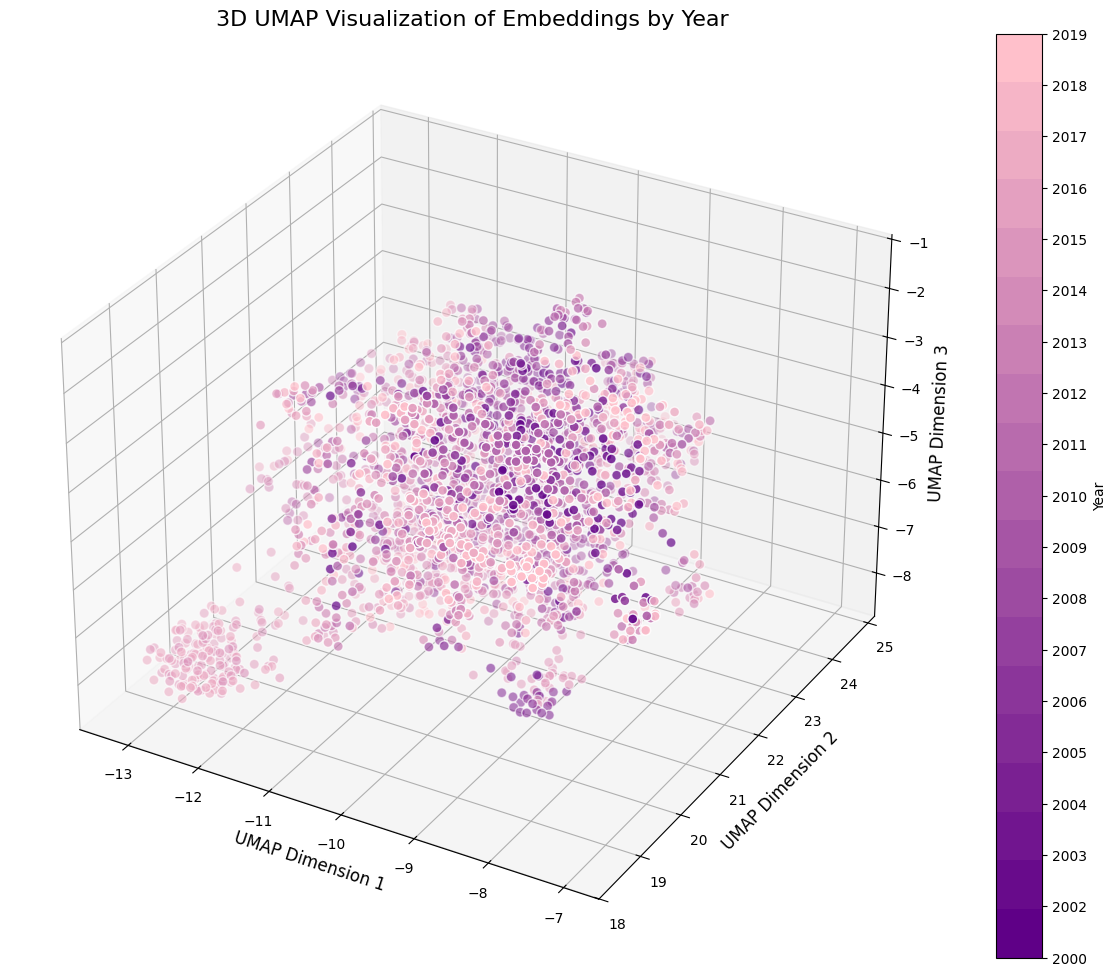

In [27]:
# add color marking by years to the UMAP plot with 3 dimensions
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    df['x_umap'], 
    df['y_umap'], 
    df['z_umap'], 
    c=df['year'].map(year_to_color),         
    cmap=gradient_colors,        
    marker='o',        
    edgecolors='w',   
    s=50,                 
)

ax.set_xlabel('UMAP Dimension 1', fontsize=12)
ax.set_ylabel('UMAP Dimension 2', fontsize=12)
ax.set_zlabel('UMAP Dimension 3', fontsize=12)
ax.set_title('3D UMAP Visualization of Embeddings by Year', fontsize=16)

cbar = fig.colorbar(sc)
cbar.set_ticks(range(len(unique_years)))
cbar.ax.set_yticklabels(unique_years)
cbar.set_label('Year')

plt.show()

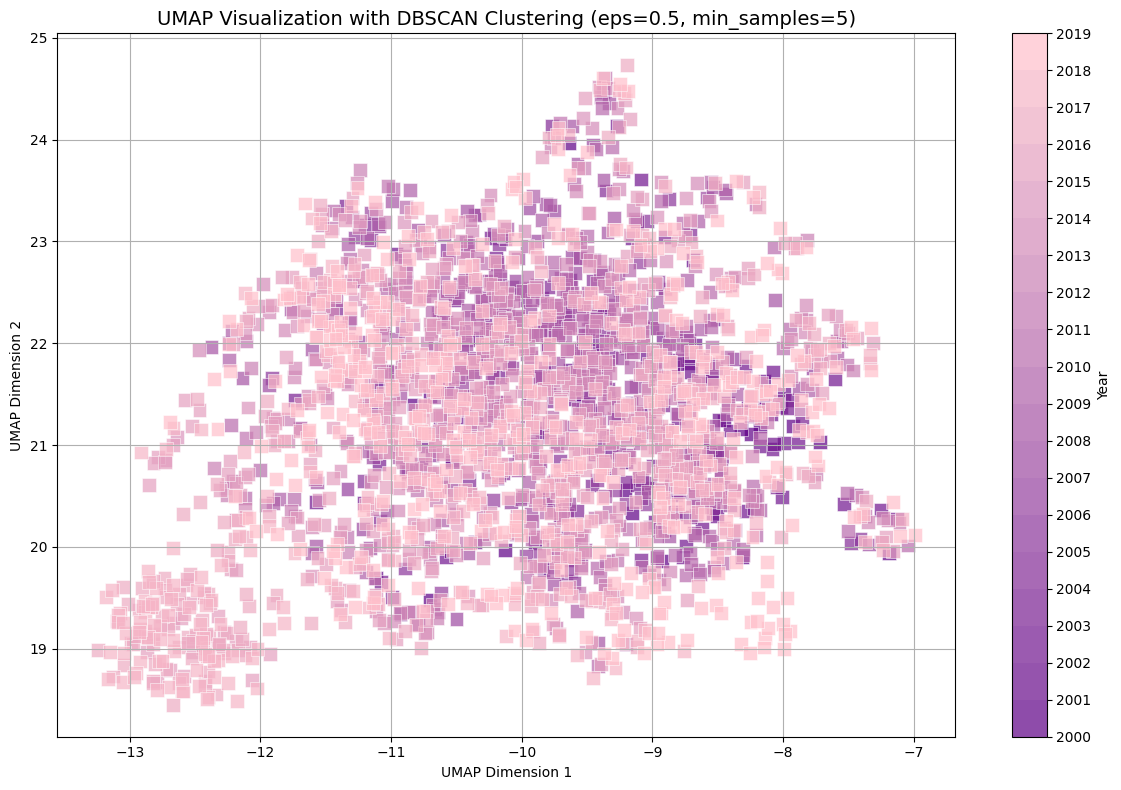

Total number of texts considered noise by DBSCAN: 2566


In [28]:
# dbscan clustering
def dbscan_clustering(matrix, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(matrix)
    return labels

def plot_clusters_dbscan(df, x_col, y_col, year_col, eps, min_samples):
    unique_clusters = sorted(df['dbscan'].unique())
    
    plt.figure(figsize=(12, 8))
    
    for idx, cluster_label in enumerate(unique_clusters):
        cluster_subset = df[df['dbscan'] == cluster_label]
        
        sc = plt.scatter(
            cluster_subset[x_col], 
            cluster_subset[y_col], 
            c=cluster_subset[year_col], 
            cmap=gradient_colors,  
            vmin=2000, vmax=2019,     
            edgecolors='k' if cluster_label != -1 else 'w',  # black outline for clusters, white for noise
            linewidths=0.8 if cluster_label != -1 else 0.5,  # thicker outline for clusters
            s=100 if cluster_label == -1 else 50,          
            marker='s' if cluster_label == -1 else 'o',   
            alpha=0.7
        )
    
    # Add plot title and labels
    plt.title(f'UMAP Visualization with DBSCAN Clustering (eps={eps}, min_samples={min_samples})', fontsize=14)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    
    # Add colorbar for year
    cbar = plt.colorbar(sc, ticks=range(2000, 2020)) 
    cbar.ax.set_yticklabels(range(2000, 2020))      
    cbar.set_label('Year')
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

eps = 0.5
min_samples = 5

df['dbscan'] = dbscan_clustering(matrix, eps=eps, min_samples=min_samples)

plot_clusters_dbscan(df, 'x_umap', 'y_umap', 'year', eps, min_samples)

total_noise = (df['dbscan'] == -1).sum()
print(f"Total number of texts considered noise by DBSCAN: {total_noise}")